Step 1: Install required Packages


In [1]:
!pip install fsspec==2024.9.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:

!pip install -q accelerate==1.1.1 peft==0.13.2 bitsandbytes==0.40.2 transformers==4.46.3 trl==0.12.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00


In [3]:
import os
import torch
from datasets import load_dataset
from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)

from peft import LoraConfig, PeftModel
from trl import  SFTTrainer

# In case of Llama 2, the following prompt template is used for the chat models.

- System Prompt optional to guide the model.
- User Prompt required to give the instruction.
- Model Answer (Required)




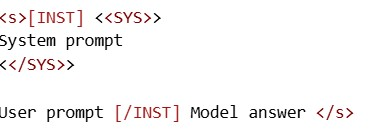

# We will reformat our instruction dataset to follow Llama 2 Template

- Orignal Dataset: https://huggingface.co/datasets/timdettmers/openassistant-guanaco
- Reformat Dataset following the Llama 2 template with 1k sample: https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k
- Complete Reformat Dataset following the Llama 2 template: https://huggingface.co/datasets/mlabonne/guanaco-llama2
- To know how this dataset was created, you can check this notebook.

https://colab.research.google.com/drive/1Ad7a9zMmkxuXTOh1Z7-rNSICA4dybpM2?usp=sharing

Note: You don’t need to follow a specific prompt template if you’re using the base Llama 2 model instead of the chat version.

## How to fine tune Llama 2
- Free Google Colab offers a 15GB Graphics Card (Limited Resources --> Barely enough to store Llama 2–7b’s weights)
- We also need to consider the overhead due to optimizer states, gradients, and forward activations
- Full fine-tuning is not possible here: we need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.
- To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.

# STEP 3

- 1.Load a llama-2-7b-chat-hf model (chat model)
- 2.Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune.
- QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [12]:
# The model used to train from the Hugging Face Hub
model_name="tiiuae/falcon-7b"

# The instruction dataset from Huggingface
dataset_name="mlabonne/guanaco-llama2-1k"

# Fine tuned Model name
new_model="Ayush12a/Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

#LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}


## Step 4:Load everything and start the fine-tuning process
- 1.First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.

- 2.Then, we’re configuring bitsandbytes for 4-bit quantization.

- 3.Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.

- 4.Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [10]:
!pip install huggingface_hub


In [13]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=1,  # Reduce batch size to save memory
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)


# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

Your GPU supports bfloat16: accelerate training with bf16=True


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:328: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

You are using 8-bit optimizers with a version of `bitsandbytes` < 0.41.1. It is recommended to update your version as a major bug has been fixed in 8-bit optimizers.


Step,Training Loss
25,1.425900
50,1.780900
75,1.197900
100,1.810000
125,1.309300
150,1.674300
175,1.168000
200,1.504700
225,1.211400
250,1.452000


TrainOutput(global_step=1000, training_loss=1.3969909954071045, metrics={'train_runtime': 819.9071, 'train_samples_per_second': 1.22, 'train_steps_per_second': 1.22, 'total_flos': 1.69759711767744e+16, 'train_loss': 1.3969909954071045, 'epoch': 1.0})

In [13]:
# Save trained model
trainer.model.save_pretrained(new_model)

##Step 6:Use the text generation pipeline to ask questions like “What is a large language model?” Note that I’m formatting the input to match Llama 2 prompt template.

In [15]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "I would like to implement simulations of chemical unit operations using Python and use them to optimize certain outputs. Which open-source packages do you recommend for this purpose? "
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

[INST] I would like to implement simulations of chemical unit operations using Python and use them to optimize certain outputs. Which open-source packages do you recommend for this purpose?  [/INST] There are many open-source packages that can be used for chemical simulations and optimization. Some of the most popular ones include:

1. [Chemkin](https://github.com/chemkin/chemkin): A Python package for chemical kinetics simulations.
2. [Chemkin-Py](https://github.com/chemkin/chemkin-py): A Python package for chemical kinetics simulations.
3. [Chemkin-GUI](https://github.com/chemkin/chemkin-gui): A Python package for chemical kinetics simulations with a graphical user interface.
4. [Chemkin-GUI-Py](https://github.com/chemkin/chemkin-gui-py): A Python package for chemical kinetics
